In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install unidecode


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from unidecode import unidecode
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')



# Read data
data = pd.read_csv('/content/drive/MyDrive/data/anthems.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)

# Filter data by continents
continents = ['Europe', 'South_America', 'North_America', 'Asia', 'Africa', 'Oceania']
data = data.loc[data['continent'].isin(continents)]

# Prepare corpus
corpus = data['anthem'].tolist()

# Process corpus
def process_corpus(corpus):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    processed_corpus = []

    for document in corpus:
        document = document.replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        document = document.replace(',', '')          # Removes commas
        document = document.rstrip('\n')              # Removes line breaks
        document = document.casefold()                # Makes all letters lowercase

        document = re.sub('\W_',' ', document)        # Removes special characters and leaves only words
        document = re.sub("\S*\d\S*"," ", document)   # Removes numbers and words concatenated with numbers

        tokens = word_tokenize(document)
        tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
        tokens = [token for token in tokens if len(token) > 2 and len(token) < 21]  # Remove short/long words
        tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
        tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens

        processed_document = " ".join(tokens)
        processed_document = unidecode(processed_document)
        processed_corpus.append(processed_document)

    return processed_corpus

corpus = process_corpus(corpus)

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
print(final_df.T.nlargest(190, 0))  # Print top features

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(X)

# Add clusters to the data
data['cluster'] = clusters

# Print some results
print(data.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


190 rows
                 0         1         2         3        4         5    6    \
albania     0.313626  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
sacr        0.284499  0.000000  0.000000  0.000000  0.08923  0.000000  0.0   
fatherland  0.230679  0.110326  0.076622  0.150422  0.00000  0.089323  0.0   
proclaim    0.222827  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
upon        0.199952  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
...              ...       ...       ...       ...      ...       ...  ...   
asia        0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
ask         0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
asleep      0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
aspir       0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   
assail      0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.0   

            7    8    9    ...  180  181  182  183  18

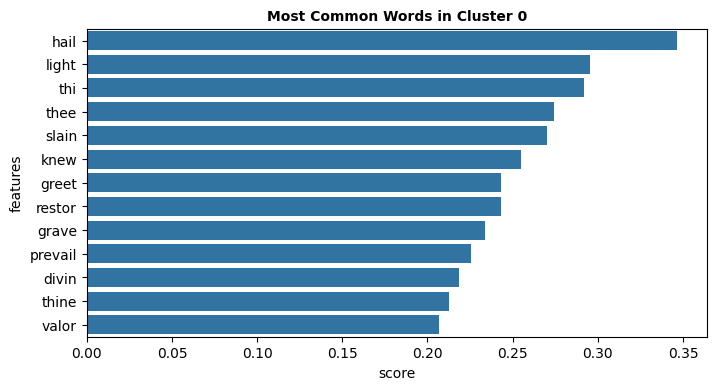

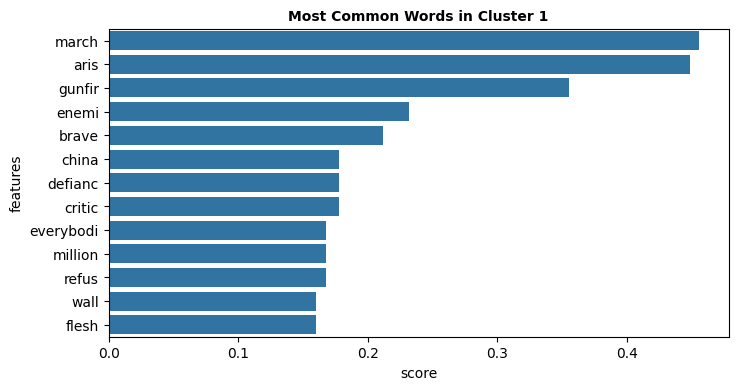

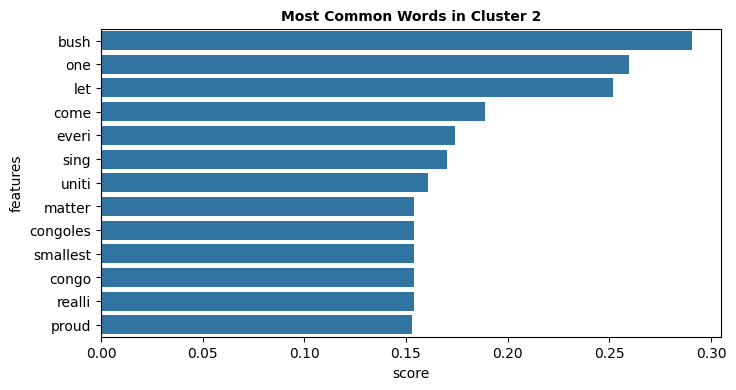

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_DBSCAN(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(data)
    return dbscan.labels_

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        if label == -1:  # Skip noise points if present
            continue
        id_temp = np.where(prediction == label)[0]  # indices for each cluster
        cluster_data = tf_idf_array[id_temp]  # data points in the cluster
        cluster_mean = np.mean(cluster_data, axis=0)  # mean of cluster data
        sorted_means = np.argsort(cluster_mean)[::-1][:n_feats]  # indices with top scores
        # Assuming you have a vectorizer object called 'vectorizer' for getting feature names
        features = np.array(vectorizer.get_feature_names_out())
        best_features = [(features[i], cluster_mean[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns=['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    for i, df in enumerate(dfs):
        plt.figure(figsize=(8, 4))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x='score', y='features', orient='h', data=df[:n_feats])
        plt.show()

# Assuming the rest of the code remains the same

# Assuming the rest of the code remains the same

# Convert final_df to numpy array
final_df_array = final_df.to_numpy()

# Running DBSCAN Clustering
eps = 0.5
min_samples = 2
prediction = run_DBSCAN(final_df_array, eps, min_samples)

# Getting top features for each cluster
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)

# Plotting top features for each cluster
plotWords(dfs, 13)  # Adjust the number of features to plot as needed



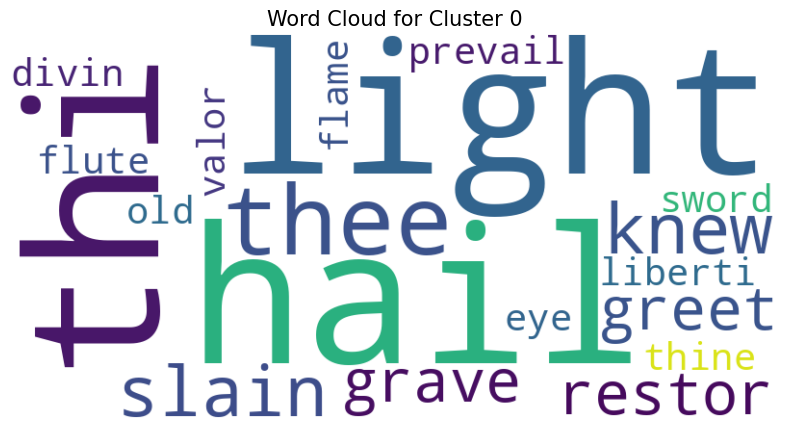

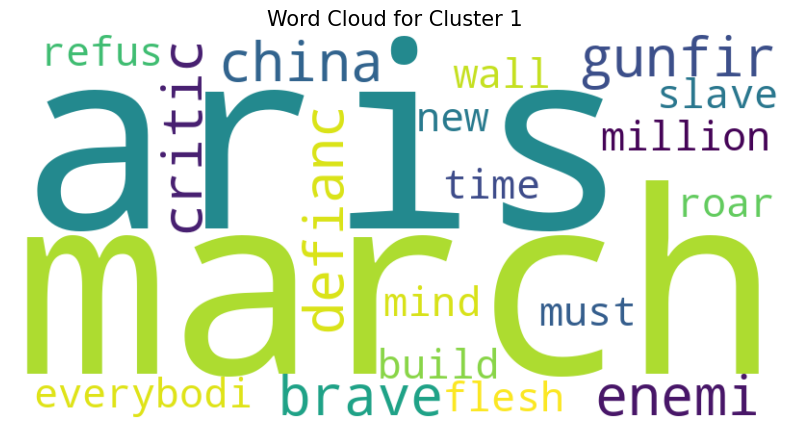

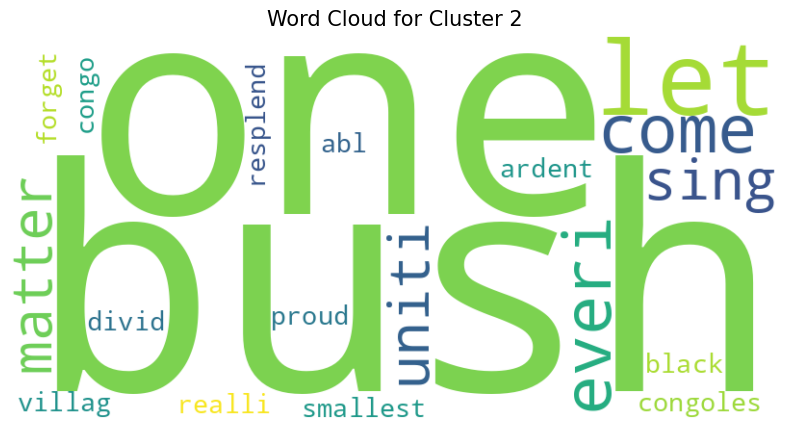

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for each cluster
for i, df in enumerate(dfs):
    # Combine words from the 'features' column into a single string
    cluster_words = ' '.join(df['features'])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_words)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {i}', fontsize=15)
    plt.axis('off')
    plt.show()
